In [15]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gp
import plotly.express as px
import skill_metrics as sm
import skill_metrics as sm
import matplotlib.pyplot as plt
import scipy.stats as scs

import spei

In [16]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

### Monthly Data

In [17]:
conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

data['Date'] = pd.to_datetime(data["Date"], format="%Y-%m")

conn.close()

### Unique Station

In [18]:
data[['Station_ID', 'Station_Name']].drop_duplicates().reset_index(drop=True)

,Station_ID,Station_Name
0,40709,Astara
1,40718,Bandar-e-anzali
2,40719,Rasht
3,40720,Manjil
4,40732,Ramsar
5,40734,Nowshahr
6,40735,Siahbisheh
7,40736,Babolsar
8,40737,Gharakhil
9,40759,Sari


### Select Stations
- Cluster 3 - Bandar-e-anzali:  40718  
- Cluster 1 - Gharakhil:        40737  
- Cluster 2 - Siahbisheh:       40735  

In [19]:
selected_stations = ["Sari", "Alasht", "Ramsar"]

data = data.query("Station_Name in @selected_stations and Date >= '2006-09' and Date < '2023-10'")

### Selected Colmns

In [20]:
scale = 24
di = 'SPEI'

sf = [
    'Station_ID',
    'Station_Name',
    'Date',
    'NDVI',
    'EVI',
    'PCI_GPM',
    'VCI',
    'TCI',
    'VHI',
    'CI_GPM',
    f'{di}_{scale}',
    f'GPM_{di}_{scale}'
]

### Filter Data

In [21]:
df = data[sf].query('Station_Name in @selected_stations').dropna(subset=[f'{di}_{scale}', f'GPM_{di}_{scale}'])

df[f'{di}_{scale}_Class'] = pd.cut(df[f'{di}_{scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{scale}_Class'] = df[f'{di}_{scale}_Class'].astype('category')

df[f'GPM_{di}_{scale}_Class'] = pd.cut(df[f'GPM_{di}_{scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'GPM_{di}_{scale}_Class'] = df[f'GPM_{di}_{scale}_Class'].astype('category')

In [22]:
df

,Station_ID,Station_Name,Date,NDVI,EVI,PCI_GPM,VCI,TCI,VHI,CI_GPM,SPEI_24,GPM_SPEI_24,SPEI_24_Class,GPM_SPEI_24_Class
879,40732,Ramsar,2008-08-01,0.541,0.316,0.145,0.825,0.274,0.550,0.415,-0.208,-0.061,NN,NN
880,40732,Ramsar,2008-09-01,0.526,0.280,0.579,0.810,0.782,0.796,0.724,-0.573,-0.070,NN,NN
881,40732,Ramsar,2008-10-01,0.585,0.292,0.547,1.000,0.688,0.844,0.745,-1.345,-0.037,MD,NN
882,40732,Ramsar,2008-11-01,0.528,0.237,0.405,0.849,0.488,0.668,0.581,-0.544,-0.111,NN,NN
883,40732,Ramsar,2008-12-01,0.408,0.180,1.000,0.537,0.719,0.628,0.752,-0.275,0.059,NN,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,99361,Alasht,2023-05-01,0.469,0.287,0.441,0.000,0.141,0.070,0.194,-2.034,-1.916,ED,SD
5123,99361,Alasht,2023-06-01,0.461,0.257,0.462,0.236,0.836,0.536,0.511,-1.778,-1.731,SD,SD
5124,99361,Alasht,2023-07-01,0.466,0.259,0.215,0.573,0.767,0.670,0.518,-1.888,-1.784,SD,SD
5125,99361,Alasht,2023-08-01,0.420,0.219,0.222,0.537,0.274,0.406,0.345,-1.978,-1.813,SD,SD


### Plot

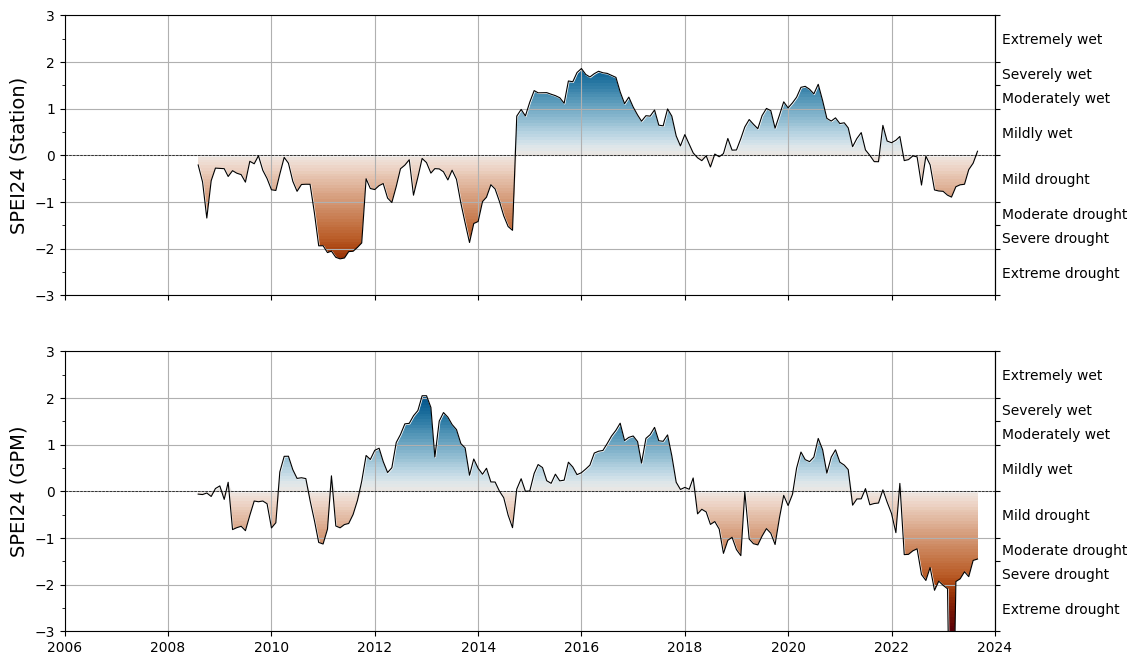

In [23]:
df_plot = df.query('Station_Name == "Ramsar"')
df_plot.set_index('Date', inplace=True)

f, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
spei.plot.si(df_plot[f'{di}_{scale}'], ax=ax[0], cmap="vik_r")
spei.plot.si(df_plot[f'GPM_{di}_{scale}'], ax=ax[1], cmap="vik_r")
ax[0].set_xlim(pd.to_datetime(["2006", "2024"]))
[x.grid() for x in ax]
[ax[i].set_ylabel(n, fontsize=14) for i, n in enumerate([f'{di}{scale} (Station)', f'{di}{scale} (GPM)'])];

### Calculate Model Evaluator

In [30]:
from sklearn.metrics import accuracy_score, classification_report

report = classification_report(df[f'{di}_{scale}_Class'], df[f'GPM_{di}_{scale}_Class'])
print(report)

              precision    recall  f1-score   support

          ED       0.00      0.00      0.00        13
          EW       0.00      0.00      0.00         3
          MD       0.02      0.04      0.03        28
          MW       0.32      0.25      0.28        77
          NN       0.77      0.75      0.76       370
          SD       0.25      0.46      0.32        24
          VW       0.24      0.23      0.23        31

    accuracy                           0.58       546
   macro avg       0.23      0.25      0.23       546
weighted avg       0.59      0.58      0.58       546



In [31]:
from utils.model_evaluator import ModelEvaluator

for st in selected_stations:
    print(f"\nMetrics for Station ID: {st}")
    ModelEvaluator(df.query('Station_Name == @st'), f'{di}_{scale}', f'GPM_{di}_{scale}').display_metrics()


Metrics for Station ID: Sari
Model Performance Metrics:
Mean Absolute Error (MAE): 0.4425
Mean Squared Error (MSE): 0.3073
Root Mean Squared Error (RMSE): 0.5544
R-squared (R2): 0.6542
Explained Variance Score: 0.6615
Willmott's Index of Agreement (WI): 0.7068
Nash–Sutcliffe Efficiency (NS): 0.6542
Mean Absolute Deviation (MAD): 0.4425

Metrics for Station ID: Alasht
Model Performance Metrics:
Mean Absolute Error (MAE): 0.4591
Mean Squared Error (MSE): 0.3156
Root Mean Squared Error (RMSE): 0.5618
R-squared (R2): 0.6398
Explained Variance Score: 0.6458
Willmott's Index of Agreement (WI): 0.6930
Nash–Sutcliffe Efficiency (NS): 0.6398
Mean Absolute Deviation (MAD): 0.4591

Metrics for Station ID: Ramsar
Model Performance Metrics:
Mean Absolute Error (MAE): 1.0037
Mean Squared Error (MSE): 1.5776
Root Mean Squared Error (RMSE): 1.2560
R-squared (R2): -0.5923
Explained Variance Score: -0.5913
Willmott's Index of Agreement (WI): 0.3759
Nash–Sutcliffe Efficiency (NS): -0.5923
Mean Absolute 

In [58]:
import plotly.express as px

for st in selected_stations:
    station_data = df.query('Station_Name == @st')
    fig = px.scatter(station_data, x=f'{di}_{scale}', y=f'GPM_{di}_{scale}', title=st)
    max_limit = max(station_data[f'{di}_{scale}'].max(), station_data[f'GPM_{di}_{scale}'].max())
    min_limit = max(station_data[f'{di}_{scale}'].min(), station_data[f'GPM_{di}_{scale}'].min())
    fig.update_layout(xaxis=dict(range=[min_limit, max_limit]), yaxis=dict(range=[min_limit, max_limit]))
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

In [43]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


x=f'{di}_{scale}'
y=f'GPM_{di}_{scale}'

for st in selected_stations:
    station_data = data.query("Station_Name == @st")[['Date', x, y]].dropna()

    fig = px.scatter(
        station_data,
        x=x,
        y=y,
        labels={
            x: f"{st}<br>{di}{scale} (Station)",
            y: f'{di}{scale} (GPM)'
        },
        opacity=0.7,
        color_discrete_sequence=["black"],  # make points black
    )

    # Make scatter markers bigger
    fig.update_traces(marker=dict(size=8, color="black"))

    # Equal axis limits
    max_limit = max(station_data[x].max(),
                    station_data[y].max()) + 0.5
    min_limit = min(station_data[x].min(),
                    station_data[y].min()) - 0.5
    
    # Equal ticks
    tick_vals = np.arange(min_limit, max_limit, 1)

    fig.update_layout(
        xaxis=dict(range=[min_limit, max_limit]),
        yaxis=dict(range=[min_limit, max_limit]),
        width=600,
        height=600,
        title=None,
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    # Add 1:1 line (hidden from legend)
    fig.add_trace(go.Scatter(
        x=[min_limit, max_limit],
        y=[min_limit, max_limit],
        mode="lines",
        line=dict(color="red", dash="dash"),
        showlegend=False
    ))

    fig.show()


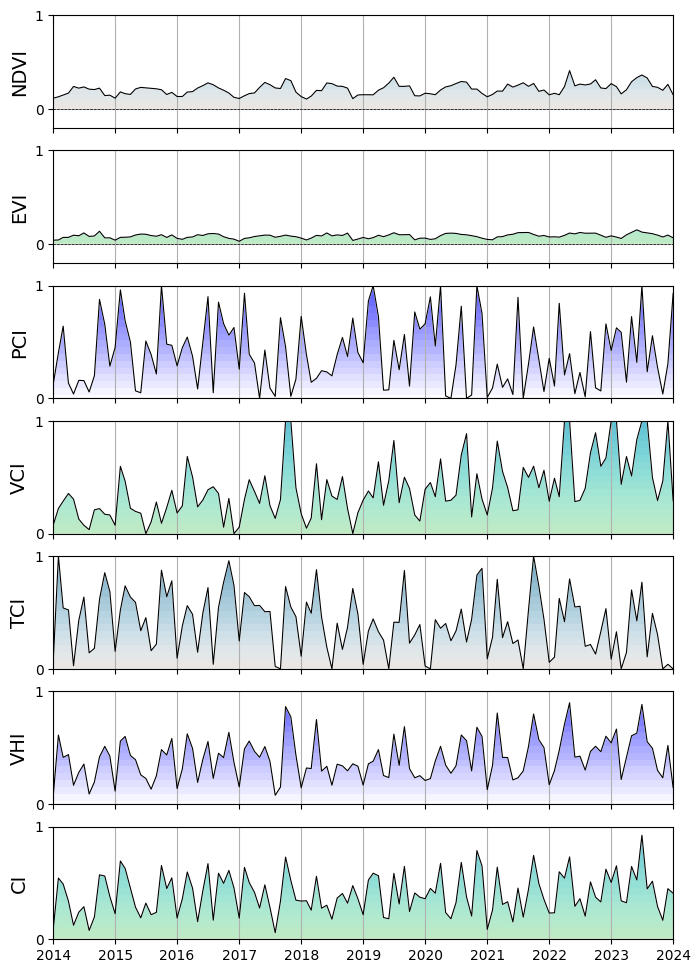

In [93]:
df_plot = df.query('Station_Name == "Bandar-e-anzali"')
df_plot.set_index('Date', inplace=True)

f, ax = plt.subplots(7, 1, figsize=(8, 12), sharex=True)
spei.plot.si(df_plot['NDVI'], ax=ax[0], cmap="vik_r")
spei.plot.si(df_plot['EVI'], ax=ax[1], cmap="roma")
spei.plot.si(df_plot['PCI_GPM'], ax=ax[2], cmap="seismic_r")
spei.plot.si(df_plot['VCI'], ax=ax[3], cmap="roma")
spei.plot.si(df_plot['TCI'], ax=ax[4], cmap="vik_r")
spei.plot.si(df_plot['VHI'], ax=ax[5], cmap="seismic_r")
spei.plot.si(df_plot['CI_GPM'], ax=ax[6], cmap="roma")
ax[0].set_xlim(pd.to_datetime(["2014", "2024"]))
ax[0].set_ylim(-0.2, 1)
ax[1].set_ylim(-0.2, 1)
ax[2].set_ylim(0, 1)
ax[3].set_ylim(0, 1)
ax[4].set_ylim(0, 1)
ax[5].set_ylim(0, 1)
ax[6].set_ylim(0, 1)
[x.grid() for x in ax]
[ax[i].set_ylabel(n, fontsize=14) for i, n in enumerate(['NDVI', 'EVI', 'PCI', 'VCI', 'TCI', 'VHI', 'CI'])];